In [1]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import tensorflow

EXTRACTION OF PRETRAINED NETWORK FROM KERAS


In [2]:
img_height, img_width = (224,224)
batch_size = 30
IMG_SHAPE = (img_height,img_width,3)
train_data_dir = r"L:/NUS/PROJECT/Augmeny_Trial_output.after.splitting-20220627T074754Z-001/Augmeny_Trial_output.after.splitting/train/"
valid_data_dir = r"L:/NUS/PROJECT/Augmeny_Trial_output.after.splitting-20220627T074754Z-001/Augmeny_Trial_output.after.splitting/val/"
test_data_dir = r"L:/NUS/PROJECT/Augmeny_Trial_output.after.splitting-20220627T074754Z-001/Augmeny_Trial_output.after.splitting/test/"
#test_data_dir = r"/content/drive/MyDrive/outputfolder/test"
#image.open()

In [3]:

train_datagen = ImageDataGenerator(
                                   shear_range=0.2,zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.4,
                                    rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                 #   subset='training')# set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as validation data  
                                                                  

Found 3074 images belonging to 4 classes.
Found 383 images belonging to 4 classes.


In [4]:
train_generator.class_indices

{'center': 0, 'closed': 1, 'left': 2, 'right': 3}

In [5]:
y_train = train_generator.classes
len(y_train)

3074

In [6]:
nb_validation_samples = 383

In [7]:
dir(train_generator)
#type(train_generator.labels)
print(train_generator.classes)
#y_train = train_generator.classes
y_train = train_generator.classes
y_train.shape

[0 0 0 ... 3 3 3]


(3074,)

In [8]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                   
                                                   batch_size = 1, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as testing data

Found 388 images belonging to 4 classes.


In [9]:
x,y = test_generator.next()
x.shape
#print(type(x))
#x

(1, 224, 224, 3)

RESNET50
ARCHITECTURE

In [25]:
def create_model():

  base_model_3 = ResNet50(include_top = False, weights='imagenet',input_shape = IMG_SHAPE)
 
 #the top layer is false coz we want to classify our own classes
#we use weights from imagenet(pre-trained weights) to classify our model
  x = base_model_3.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(2048, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)
  model = Model(inputs=base_model_3.input, outputs=predictions)

  for layer in base_model_3.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.001)#learning rate as 0.01
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

#plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [26]:
# 100 epochs for Resnet50 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
checkpoint_path = "L:/NUS/PROJECT/Output_folder-20220623T072421Z-001/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 50,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/50
129/129 [==============================] - ETA: 0s - loss: 1.5530 - accuracy: 0.2909 - mse: 0.1998
Epoch 1: val_accuracy improved from -inf to 0.26933, saving model to L:/NUS/PROJECT/Output_folder-20220623T072421Z-001\cp-0021.ckpt.data-00000-of-00001
129/129 [==============================] - 221s 2s/step - loss: 1.5530 - accuracy: 0.2909 - mse: 0.1998 - val_loss: 1.3245 - val_accuracy: 0.2693 - val_mse: 0.1811 - lr: 0.0010
Epoch 2/50
129/129 [==============================] - ETA: 0s - loss: 1.3536 - accuracy: 0.3201 - mse: 0.1834
Epoch 2: val_accuracy improved from 0.26933 to 0.38133, saving model to L:/NUS/PROJECT/Output_folder-20220623T072421Z-001\cp-0021.ckpt.data-00000-of-00001
129/129 [==============================] - 210s 2s/step - loss: 1.3536 - accuracy: 0.3201 - mse: 0.1834 - val_loss: 1.3142 - val_accuracy: 0.3813 - val_mse: 0.1772 - lr: 0.0010
Epoch 3/50
129/129 [==============================] - ETA: 0s - loss: 1.3549 - accuracy: 0.3223 - mse: 0.1833
Epoch 3: 

In [29]:
model.save('resnet50.h5')

In [31]:
model = tensorflow.keras.models.load_model('resnet50.h5')

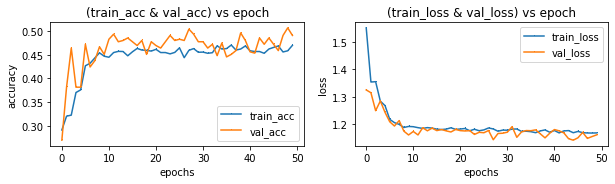

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [33]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
f.savefig('L:/NUS/PROJECT', bbox_inches='tight', dpi=600)

In [35]:
pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
Note: you may need to restart the kernel to use updated packages.


1/1 [==============================] - 0s 87ms/step


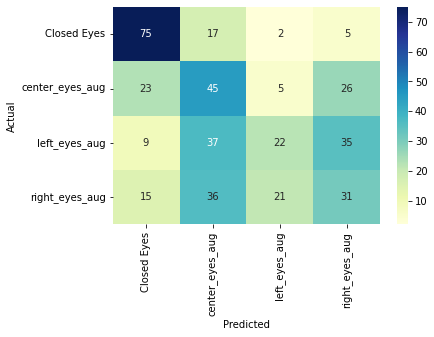

test accuracy: 42.82178217821782


In [38]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
model_1 = model
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [39]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['Closed Eyes', 'center_eyes_aug', 'left_eyes_aug', 'right_eyes_aug']

ROC AUC score: 0.625404437989517


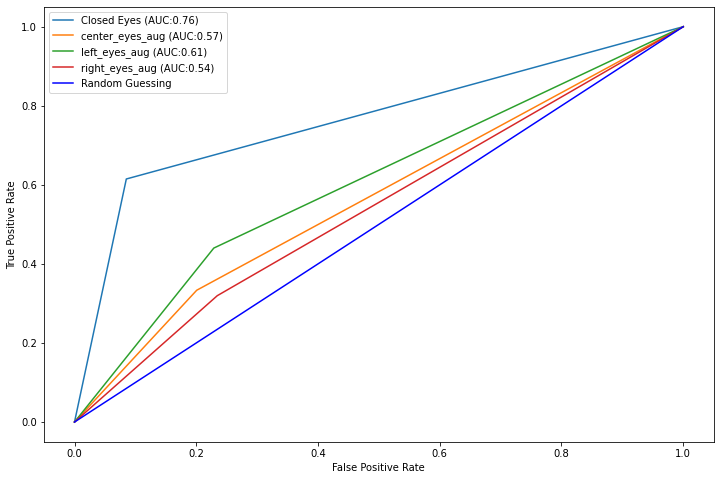

In [40]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [42]:
model_ = tensorflow.keras.models.load_model('resnet50.h5')

In [45]:
result = model_.evaluate(test_generator)
dict(zip(model_.metrics_names,result))

404/404 [==============================] - 36s 87ms/step - loss: 1.1727 - accuracy: 0.4381 - mse: 0.1613


{'loss': 1.1727197170257568,
 'accuracy': 0.4381188154220581,
 'mse': 0.16132186353206635}

In [49]:
#finetuning
for layer in model_.layers:
    layer.trainable = True
    print("number of layers in model_1:", len(model_.layers))
    fine_tune_at = 140
for layer in model_.layers[:fine_tune_at]:
    layer.trainable = False

opt = keras.optimizers.Adam(learning_rate=0.00001)#learning rate as 0.01
model_.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

model_1 = model_
model_1.summary()

number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of layers in model_1: 178
number of 

In [51]:
# 100 epochs for Resnet50 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
model = model_
checkpoint_path = "L:/NUS/PROJECT/Output_folder-20220623T072421Z-001/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 30,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/30
129/129 [==============================] - ETA: 0s - loss: 1.1385 - accuracy: 0.4707 - mse: 0.1535
Epoch 1: val_accuracy improved from -inf to 0.25333, saving model to L:/NUS/PROJECT/Output_folder-20220623T072421Z-001\cp-0021.ckpt.data-00000-of-00001
129/129 [==============================] - 324s 3s/step - loss: 1.1385 - accuracy: 0.4707 - mse: 0.1535 - val_loss: 9.5393 - val_accuracy: 0.2533 - val_mse: 0.3713 - lr: 1.0000e-05
Epoch 2/30
129/129 [==============================] - ETA: 0s - loss: 0.9514 - accuracy: 0.5172 - mse: 0.1366
Epoch 2: val_accuracy improved from 0.25333 to 0.29333, saving model to L:/NUS/PROJECT/Output_folder-20220623T072421Z-001\cp-0021.ckpt.data-00000-of-00001
129/129 [==============================] - 328s 3s/step - loss: 0.9514 - accuracy: 0.5172 - mse: 0.1366 - val_loss: 2.2672 - val_accuracy: 0.2933 - val_mse: 0.2853 - lr: 1.0000e-05
Epoch 3/30
129/129 [==============================] - ETA: 0s - loss: 0.9137 - accuracy: 0.5331 - mse: 0.1324
E

In [52]:
model.save('resnet50_fine_tuning.h5')

In [ ]:
#to find the number of images in a file

In [53]:
result = model.evaluate(test_generator)
dict(zip(model.metrics_names,result))

404/404 [==============================] - 39s 98ms/step - loss: 0.9184 - accuracy: 0.5619 - mse: 0.1317


{'loss': 0.918368935585022,
 'accuracy': 0.5618811845779419,
 'mse': 0.13174143433570862}

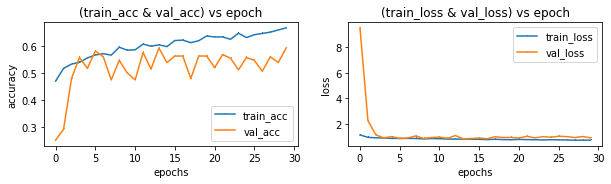

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [54]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
f.savefig('L:/NUS/PROJECT', bbox_inches='tight', dpi=600)

In [87]:
APP_FOLDER = 'G:/final_dataset/train/'
#APP_FOLDER = "C:/Users/DHANVANTH/SAMSUNG/y"
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

print('Total number of files',totalFiles)


Searching in :  G:/final_dataset/train/reflection absent
Total number of files 800
